In [59]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F

In [60]:
from torchvision.models import resnet50

In [61]:
model = resnet50(pretrained=True).eval()

In [62]:
from PIL import Image
import torchvision.transforms.functional as TF

In [63]:
my_img = Image.open('Elephant2.jpg')

In [64]:
#This is my normalize method which gives a prdiction of 'African_elephant' instead of 'tusker', and then I use the given value
tmp_process = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
tmp_tensor = tmp_process(my_img)[None,:,:,:]

Rchan = tmp_tensor[:,0,:]
Gchan = tmp_tensor[:,1,:]
Bchan = tmp_tensor[:,2,:]

Rchan_mean = Rchan.mean()
Gchan_mean = Gchan.mean()
Bchan_mean = Bchan.mean()

Rchan_std = Rchan.std()
Gchan_std = Gchan.std()
Bchan_std = Bchan.std()

mean=[Rchan_mean,Gchan_mean,Bchan_mean]
std= [Rchan_std,Gchan_std,Bchan_std]

preprocess = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),torchvision.transforms.Normalize(mean,std)])
my_tensor = preprocess(my_img)[None,:,:,:]

In [65]:
# mean = [0.485, 0.456, 0.406]
# std =[0.229, 0.224, 0.225] 
# preprocess = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),torchvision.transforms.Normalize(mean,std)])
# my_tensor = preprocess(my_img)[None,:,:,:]

In [66]:
pred_vector = model(my_tensor)

In [67]:
pred_vector_list = pred_vector.tolist()[0]

In [68]:
class_pred = pred_vector_list.index(max(pred_vector_list))

In [69]:
import json
with open('imagenet_class_index.json', 'r') as myfile:
    data=myfile.read()
obj = json.loads(data)

In [70]:
obj[str(class_pred)]

['n01871265', 'tusker']

In [71]:
pred_vector.shape

torch.Size([1, 1000])

In [72]:
my_variable = Variable(my_tensor, requires_grad=True)

In [73]:
output = model.forward(my_variable)

In [74]:
target = Variable(torch.LongTensor([101]), requires_grad=False)

In [75]:
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(output, target)
loss.backward(retain_graph=True)

In [76]:
img_grad = my_variable.requires_grad_().sign()

In [77]:
img_adversarial = my_variable.data - 0.12 * img_grad

In [78]:
pred_adversarial = model(img_adversarial)

In [79]:
class_adversarial = pred_adversarial.tolist()[0].index(max(pred_adversarial.tolist()[0]))

In [80]:
obj[str(class_adversarial)]

['n02504458', 'African_elephant']

In [81]:
x_adv = img_adversarial.squeeze(0)
x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()
x_adv = np.transpose(x_adv, (1,2,0))
x_adv = np.clip(x_adv, 0, 1)

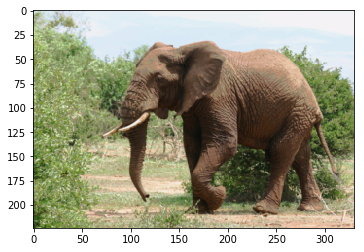

In [82]:
plt.imshow(x_adv)

In [83]:
y_adv = my_tensor.squeeze(0)
y_adv = y_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).detach().numpy()
y_adv = np.transpose(y_adv, (1,2,0))   # C X H X W  ==>   H X W X C
y_adv = np.clip(y_adv, 0, 1)

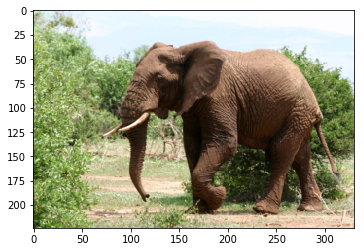

In [84]:
plt.imshow(y_adv)

In [85]:
pred_vector.tolist()[0][101]

19.06300163269043

In [88]:
pred_vector.tolist()[0][386]

19.02749252319336

In [86]:
pred_adversarial.tolist()[0][101]

18.450204849243164

In [87]:
pred_adversarial.tolist()[0][386]

18.487672805786133

In [ ]:
#Make it a bullet-train which has lie_index 466

In [43]:
my_variable = Variable(my_tensor, requires_grad=True)
output = model.forward(my_variable)

In [44]:
lie_target = Variable(torch.LongTensor([466]), requires_grad=False)

In [45]:
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(output, lie_target)
loss.backward(retain_graph=True)

In [51]:
from torch.autograd.gradcheck import zero_gradients

In [52]:
num_steps = 10

In [56]:
for i in range(num_steps):
    zero_gradients(my_variable)
    output = model(my_variable)
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(output, lie_target)
    loss.backward(retain_graph=True)
    lie_grad = my_variable.requires_grad_().sign()
    tmp_adversarial = my_variable - 0.02 * lie_grad
    sum_grad = tmp_adversarial - my_variable
    #sum_grad = torch.clamp(sum_grad, -0.2, 0.2)
    lie_adversarial = my_variable + sum_grad

In [57]:
lie_predict = model(lie_adversarial)
lie_class = lie_predict.tolist()[0].index(max(lie_predict.tolist()[0]))
obj[str(lie_class)]

['n01871265', 'tusker']

In [58]:
lie_predict.tolist()[0][466]

-2.862060070037842